### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (10, 8)

datadir = '/content/drive/MyDrive/Kaggle/data/'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Data Dictionary**
* `Survived` : Survival, 0 = No, 1 = Yes

* `Pclass` : Ticket class, 1 = 1st, 2 = 2nd, 3 = 3rd

* `Sex` : Sex

* `Age:` Age in years

* `SibSp`: Number of siblings / spouses aboard the Titanic

* `Parch`: Number of parents / children aboard the Titanic

* `Ticket`: Ticket number

* `Fare`: Passenger fare

* `Cabin`: Cabin number

* `Embarked`: Part of Embarkation, C = Cherbourg, Q = Queenstown, S = Southampton

# **Variable Notes**
* `Pclass`: A proxy for socio-economic status (SES) 1st = Upper 2nd = Middle 3rd = Lower

* `Age`: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

* `SibSp`: The number of siblings/spouses

* `Parch`: The number of parents/children

Some children travelled only with a nanny, therefore parch=0 for them.

### EDA
___
We'll start off by exploring the dataset to get familiar with the format of the entries and we can seek any missing values and try to determine some possible ways to deal with those missing values. We then further explore the data to try to find some meaningful features that already exist and we can determine if can create extra features from existing ones.

In [3]:
train = pd.read_csv(datadir + 'train.csv')

In [4]:
train.isnull().sum(axis=0) # missing entries

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
np.round(train.isnull().sum(axis=0) / len(train) * 100, 2) # percentage missing

PassengerId     0.00
Survived        0.00
Pclass          0.00
Name            0.00
Sex             0.00
Age            19.87
SibSp           0.00
Parch           0.00
Ticket          0.00
Fare            0.00
Cabin          77.10
Embarked        0.22
dtype: float64

Preliminary findings:

* The cabin feature has 77% of entries missing, it might just be worth it to drop the entire feature.
* Age has about 20% or 177 missing entries. We can impute the missing values by either the mean, median or random sampling with the features mean and std.
* One possible way that we can use Age would be to scale it (i.e. Z-score or min-max)
* There are 2 entries missing in embarked. We can either drop those 2 entries, randomly assigned via sampling, or we can inpute it with most common value.

In [6]:
train.sort_values(by='Ticket').head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
504,505,1,1,"Maioni, Miss. Roberta",female,16.0,0,0,110152,86.50,B79,S
257,258,1,1,"Cherry, Miss. Gladys",female,30.0,0,0,110152,86.50,B77,S
759,760,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,0,0,110152,86.50,B77,S
262,263,0,1,"Taussig, Mr. Emil",male,52.0,1,1,110413,79.65,E67,S
558,559,1,1,"Taussig, Mrs. Emil (Tillie Mandelbaum)",female,39.0,1,1,110413,79.65,E67,S


Let's now take a look at the reletionship between some of the features and our target `Survived`.

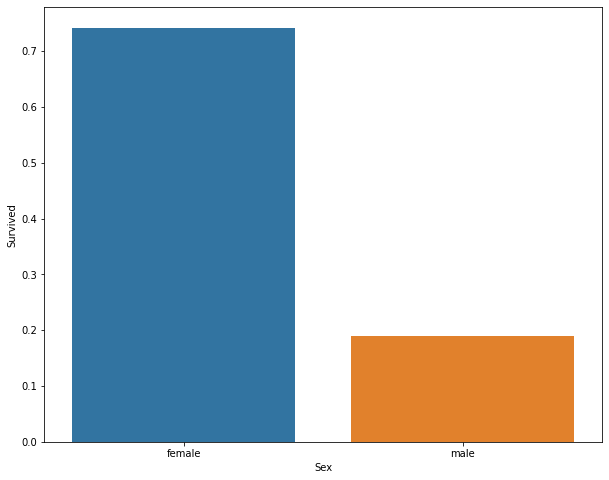

In [7]:
by_gender = train[['Sex', 'Survived']].groupby('Sex', as_index=False).agg(np.mean)
sns.barplot(data=by_gender, x='Sex', y='Survived');

It seems that a higher proportion of females survived compared to males.

In [8]:
def age_bin(age):
  if age < 12:
    return 1
  if age >= 12 and age < 18:
    return 2
  if age >= 18 and age < 25:
    return 3
  if age >= 25 and age < 50:
    return 4
  if age >= 50 and age < 60:
    return 5

  return 6

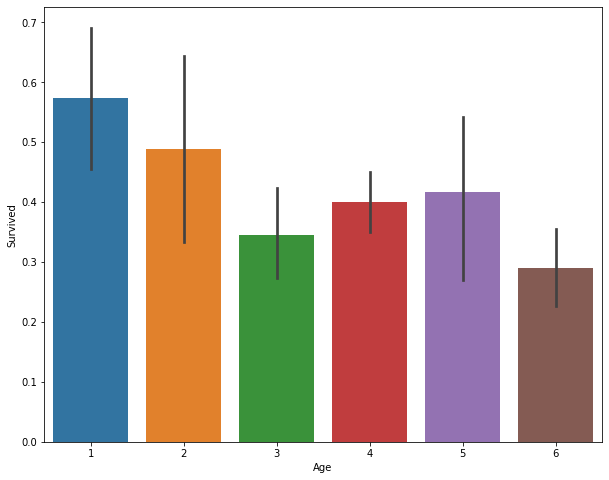

In [9]:
binned_age = train.Age.apply(age_bin)
sns.barplot(x=binned_age, y=train['Survived']);

Based on how we binned age, it is clear that age was an important factor for survival, specially for passengers younger that 12 years old.

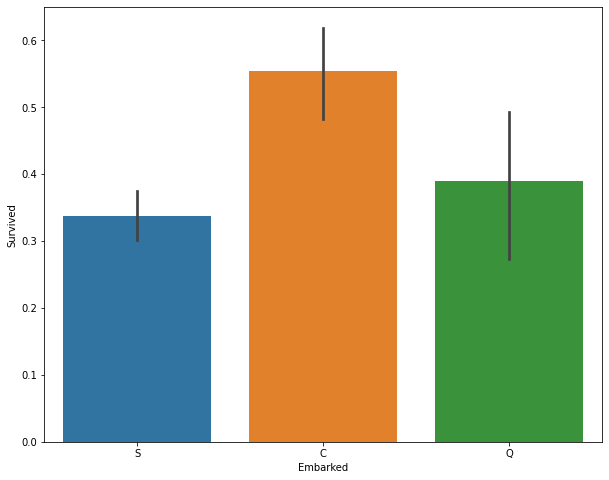

In [10]:
sns.barplot(data=train, x='Embarked', y='Survived');

From the plot we can infer that most survivors boarded the Titanic from Cherbourg.

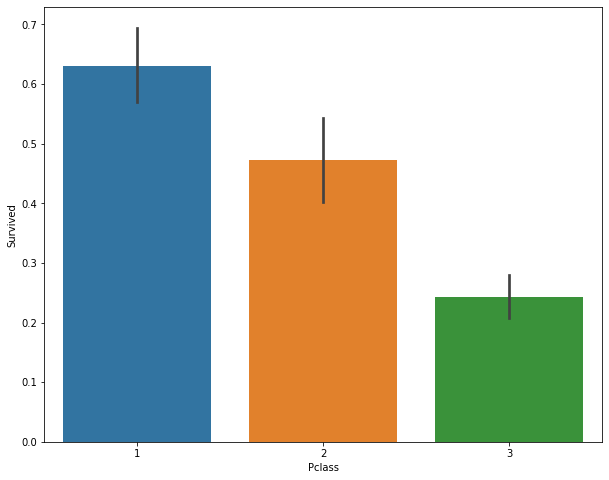

In [11]:
sns.barplot(data=train, x='Pclass', y='Survived');

First class passengers had a higher rate of survival.

### Data Preprocesing 2
___

In [12]:
train = pd.read_csv(datadir + 'train.csv', index_col=0)
test = pd.read_csv(datadir + 'test.csv', index_col=0)

**Sex** turn into binary

In [13]:
train['Sex'] = train.Sex.replace({'male': 0, 'female':1})
test['Sex'] = test.Sex.replace({'male': 0, 'female':1})

**Embarked** - convert to numeric values After inputting missing values in training set. We will OHE.

In [14]:
most_common = train.groupby('Embarked').count().sort_values('Survived', ascending=False).index.to_numpy()[0]
train['Embarked'] = train['Embarked'].fillna(most_common)

**Name** - Extract Titles, then we'll turn into numeric using OHE.

In [15]:
train.Name.str.extract(' ([A-Za-z]+)\.', expand=False).unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

In [16]:
test.Name.str.extract(' ([A-Za-z]+)\.', expand=False).unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Ms', 'Col', 'Rev', 'Dr', 'Dona'],
      dtype=object)

In [17]:
desired_titles = np.array(['Mr', 'Mrs', 'Miss']) # Cap >> Col >> Major in military rankings

In [18]:
train['Title'] = train.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
train['Title'] = train.Title.replace('Ms', 'Miss').replace('Mme', 'Mrs').replace('Mlle', 'Miss')
unique_titles = train.Title.unique()
train['Title'] = train.Title.replace(unique_titles[[title not in desired_titles for title in unique_titles]], 'Other')

# there are less titles to replace on the test set
test['Title'] = test.Name.str.extract(' ([A-Za-z]+)\.', expand=False).replace('Ms', 'Miss')
unique_titles = test.Title.unique()
test['Title'] = test.Title.replace(unique_titles[[title not in desired_titles for title in unique_titles]], 'Other')

**SIBPS & PARCH** - create new feature `Party_Size`.

In [19]:
train['Party_Size'] = train['SibSp'] + train['Parch'] + 1
test['Party_Size'] = test['SibSp'] + test['Parch'] + 1

**Age** - There are missing values for both training and testing datasets. Let's inpute by drawing from a normal distribution with the same mean and std, this way, we can hopefully get a better representaion of the sampling distribution. We will then place into age groups.

In [20]:
missing_age_train = train.Age.isna()
missing_age_test = test.Age.isna()

In [21]:
μtrain = train.Age.mean()
σtrain = train.Age.std()

μtest = test.Age.mean()
σtest = test.Age.std()

In [22]:
np.random.seed(43)
# We place a random seed to ensure reproducibility

train['Age'][missing_age_train] = np.random.normal(μtrain, σtrain, missing_age_train.sum())
test['Age'][missing_age_test] = np.random.normal(μtest, σtest, missing_age_test.sum())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [23]:
print('No missing Values!' if train.Age.isna().sum() == test.Age.isna().sum() == 0 else 'There are still missing values...')

No missing Values!


We now split into age groups. For this we'll split into as little as possible to avoid overfitting. The categories are as follows:
* Age < 12 child, `bin 1`
* 12 ≤ Age < 18 teenager, `bin 2`
* 18 ≤ Age < 25 Young Adult, `bin 3`
* 25 ≤ Age < 50 Adult, `bin 4`
* 50 ≤ Age < 65 Middle Aged, `bin 5`
* Age ≥ 65 senior citizen, `bin 6`

In [24]:
def age_bin(age):
  if age < 12:
    return 1
  if age >= 12 and age < 18:
    return 2
  if age >= 18 and age < 25:
    return 3
  if age >= 25 and age < 50:
    return 4
  if age >= 50 and age < 60:
    return 5

  return 6

In [25]:
train['Age'] = train.Age.apply(age_bin)
test['Age'] = test.Age.apply(age_bin)

**Fare** - There's one missing value in the test set, we will impute with the global mean.

In [26]:
global_mean = (train.Fare.mean() + test.Fare.mean()) / 2
test['Fare'] = test.Fare.fillna(global_mean)

**Final Clean Up** - At this point we will get rid of all the columns we've already used to make new numerical features such as `Name`, `SibSp` and `Parch`. We also drop features we will not use (`Ticket`, `Cabin`). We will finish by OHE `Title` and `Embarked`.

In [27]:
train = train.drop(columns=['Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'])
test = test.drop(columns=['Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'])

In [28]:
from sklearn.feature_extraction import DictVectorizer

vec = DictVectorizer()
categories = ['Title', 'Embarked']
train_features = train[categories]
test_features = test[categories]

In [29]:
# Performing OHE
train[vec.get_feature_names_out()] = vec.fit_transform(train_features.to_dict('records')).toarray()
test[vec.get_feature_names_out()] = vec.transform(test_features.to_dict('records')).toarray()

In [30]:
# we now drop those categories since they are OHE
train = train.drop(columns=categories)
test = test.drop(columns=categories)

**Let's take a look at our final dataset.** 

No more categorical values, only numerical and we've now handled all of the missing values.

In [31]:
train.isna().sum()

Survived       0
Pclass         0
Sex            0
Age            0
Fare           0
Party_Size     0
Embarked=C     0
Embarked=Q     0
Embarked=S     0
Title=Miss     0
Title=Mr       0
Title=Mrs      0
Title=Other    0
dtype: int64

In [32]:
test.isna().sum()

Pclass         0
Sex            0
Age            0
Fare           0
Party_Size     0
Embarked=C     0
Embarked=Q     0
Embarked=S     0
Title=Miss     0
Title=Mr       0
Title=Mrs      0
Title=Other    0
dtype: int64

### Final dataset
___
For now we will drop the `cabin` feature and clean up the table from the rest of the features we didn't use.

In [33]:
# our final table
train.head()

,Survived,Pclass,Sex,Age,Fare,Party_Size,Embarked=C,Embarked=Q,Embarked=S,Title=Miss,Title=Mr,Title=Mrs,Title=Other
PassengerId,,,,,,,,,,,,,
1,0,3,0,3,7.2500,2,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,1,1,1,4,71.2833,2,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,3,1,4,7.9250,1,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,1,1,1,4,53.1000,2,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5,0,3,0,4,8.0500,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [34]:
# our final table
train.head()

,Survived,Pclass,Sex,Age,Fare,Party_Size,Embarked=C,Embarked=Q,Embarked=S,Title=Miss,Title=Mr,Title=Mrs,Title=Other
PassengerId,,,,,,,,,,,,,
1,0,3,0,3,7.2500,2,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,1,1,1,4,71.2833,2,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,3,1,4,7.9250,1,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,1,1,1,4,53.1000,2,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5,0,3,0,4,8.0500,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0


### Model Training
___

In [35]:
# Importing models + optimization and performance metrics
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score

In [36]:
X_train = train.drop(columns=['Survived'])
Y_train = train['Survived']

X_test = test.copy()

#### Random Forest Regressor Optimization

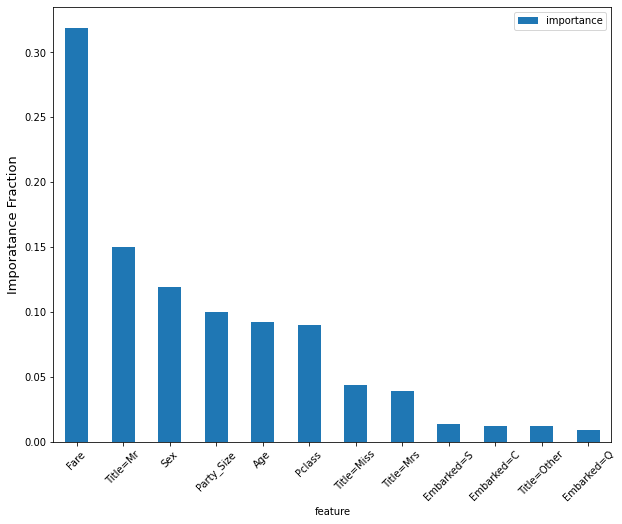

In [42]:
# Before performing any optimization, lets just take a look at what our feature engineering turn out like.
# To do this, we can use RandomForestClassifier's function to determine the feature importance.
model = RandomForestClassifier(random_state=43)

model.fit(X_train, Y_train)
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(model.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar()
plt.xticks(rotation=45)
plt.ylabel('Imporatance Fraction', size=13);
# plt.savefig('Imporatance', dpi=300)

In [43]:
# Let's see how it would do it does prior to optimization. We can estimate it's performance using cross validation
RF = RandomForestClassifier(random_state=43)
scores = cross_val_score(RF, X_train, Y_train, cv=5)
print('Scores: ', scores)
print('Mean score: ', scores.mean())

Scores:  [0.76536313 0.7752809  0.84269663 0.79213483 0.84269663]
Mean score:  0.8036344234511331


In [ ]:
# Optimizing the model (Random Forest)
RF = RandomForestClassifier(random_state=43)

params_RF = {
    'n_estimators' : [25, 50, 100, 200, 300],
    'criterion' : ['gini'],
    'max_depth' : [5, 10, 15, 20, 25],
    'min_samples_split' : [0.5, 1.0, 5, 10, 15],
    'min_samples_leaf' : [1, 2, 5]
}

best_RF = GridSearchCV(RF, params_RF, cv=5, verbose=1)

In [ ]:
best_RF.fit(X_train, Y_train)
print(f'Best Score : {best_RF.best_score_}')
print(f'Best parameters : {best_RF.best_params_}')

Fitting 5 folds for each of 375 candidates, totalling 1875 fits
Best Score : 0.8406503044378884
Best parameters : {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 25}


This certainly beats our initial accuracy, lets use some metrics to determine its performance.

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.model_selection import cross_val_predict
import seaborn as sns

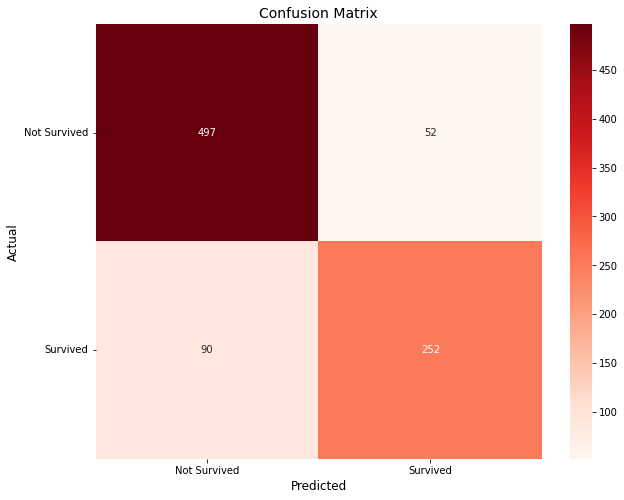

In [ ]:
yhat = cross_val_predict(best_RF.best_estimator_, X_train, Y_train, cv=5)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(Y_train, yhat), annot=True, cmap='Reds', fmt='d')
plt.title('Confusion Matrix', size=14)
plt.xlabel('Predicted', size=12)
plt.ylabel('Actual', size=12)
labels = ['Not Survived', 'Survived']
plt.yticks(ticks=[0.5, 1.5], labels=labels, rotation=0)
plt.xticks(ticks=[0.5, 1.5], labels=labels)
plt.savefig('Titanic_confusion_matrix.png', dpi=300);

From our confustion matrix, we can get a sense on what our model is missclassifying. The first row shows that 497 passenger were correctly classified as `not_survived`, our *True False*, while 52 passengers were incorrectly classified as `survived` were in fact they did not survived, this is our *False Positive*. On the second row we see that 90 passengers were incorrectly predicted as `not_survived` were in fact they had survived, this are our *False negative*. Lastly, 252 passengers were correctly classified as `survived`, this are our *True Positives*. From this confussion matrix alone we could calculate values like precision ($\frac{TP}{TP + FP}$) and recall ($\frac{TP}{P}$), which we do both in the next cell but know we can do this by hand.

In [ ]:
print("Precision:", round(precision_score(Y_train, yhat), 3))
print("Recall:", round(recall_score(Y_train, yhat), 3))

Precision: 0.829
Recall: 0.737


#### XGB random Forest Optimization

In [ ]:
xgb = XGBClassifier(objective='binary:logistic', eval_metric='error', random_state=1)
scores = cross_val_score(xgb, X_train, Y_train, cv=5)
print('Scores: ', scores)
print('Mean score: ', scores.mean())

Scores:  [0.80446927 0.82022472 0.85955056 0.82022472 0.83146067]
Mean score:  0.827185989580064


In [ ]:
xgb = XGBClassifier(objective='binary:logistic', eval_metric='error', random_state=43)#, eta=1e-4

params_xgb = {
    # 'booster' : ['gbtree', 'dart'],
    'n_estimators' : [50, 75, 100, 500],
    # 'eval_metric' : ['error', 'aucpr'],
    'eta' : [1e-1, 1e-2, 2e-1, 5e-1], # learning_rate
    # 'gamma': [0, 5e-6, 1e-5, 5e-5],
    'max_depth': [3, 10, 15, 20],
    'min_child_weight' : [1, 5, 7, 10]

}

best_xgb = GridSearchCV(xgb, params_xgb, cv=5, verbose=1)

In [ ]:
best_xgb.fit(X_train, Y_train)

print(f'Best Score achieved = {best_xgb.best_score_}')
print(f'Best Parameters = {best_xgb.best_params_}')

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
Best Score achieved = 0.8485091959073504
Best Parameters = {'eta': 0.1, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 500}


### Final submission model
___

In [ ]:
#@title Random forest final
best_params_RF = best_RF.best_params_

RF = RandomForestClassifier(
    random_state = 1,
    n_estimators = best_params_RF['n_estimators'],
    criterion = best_params_RF['criterion'],
    max_depth = best_params_RF['max_depth'],
    min_samples_split = best_params_RF['min_samples_split'],
    min_samples_leaf = best_params_RF['min_samples_leaf']
    )


RF.fit(X_train, Y_train)
y_pred = RF.predict(X_train)

RF.score(X_train, Y_train) # 93.93, 0.8945, 0.8978, 0.899

0.8821548821548821

In [ ]:
#@title XGB Random Forest Final
best_params_xgb = best_xgb.best_params_

xgb = XGBClassifier(objective='binary:logistic', eval_metric='error', random_state=43,
                      n_estimators= best_params_xgb['n_estimators'],
                      eta = best_params_xgb['eta'],
                      max_depth = best_params_xgb['max_depth'],
                      min_child_weight = best_params_xgb['min_child_weight'],
                      )

xgb.fit(X_train, Y_train)
y_pred = xgb.predict(X_train)

xgb.score(X_train, Y_train) #0.936026936026936

0.8810325476992144

In [ ]:
#@title Submision file for xgb predictions
xgb_pred = xgb.predict(X_test)
X_test['Survived'] = xgb_pred
submission = X_test[['Survived']]

save_dir = '/content/drive/MyDrive/Kaggle/data/xgbprediction.csv'
submission.to_csv(save_dir, index=True)

In [ ]:
#@title Submission for RF predictions
RF_pred = RF.predict(X_test)
X_test['Survived'] = RF_pred
submission = X_test[['Survived']]

save_dir = '/content/drive/MyDrive/Kaggle/data/RFprediction.csv'
submission.to_csv(save_dir, index=True)